In [250]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,Adadelta,SGD
from tensorflow.keras.losses import huber
import tensorflow_addons as tfa
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import argparse
import locale
import glob
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# Test the Preprocessing  of the image

In [2]:
def plt_imshow(title,image):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.show()

In [3]:
image=cv2.imread("images/aaaczjgk.png")
(h,w,_)=image.shape
cY,cX=h//2,w//2
print("Image Original Shape:",image.shape)

Image Original Shape: (150, 150, 3)


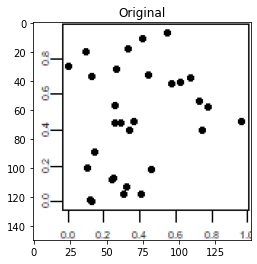

In [4]:
plt_imshow("Original",image)

In [5]:
#Preproccess
#Convert to grayscale image since we do not need RGB Images
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image=image[0:125,20:145]
ratio=32/w
# Doing threshold to make sure we only have 0 and 255 value
image=cv2.resize(image,(64,64),cv2.INTER_AREA)
thresh,image=cv2.threshold(image,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print("Image shape:",image.shape)

Image shape: (64, 64)


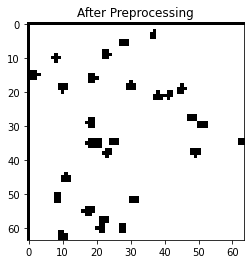

In [6]:
plt_imshow("After Preprocessing",image)

In [355]:
df=pd.read_csv("responses.csv")

<AxesSubplot:ylabel='Frequency'>

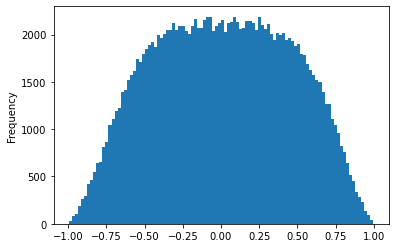

In [358]:
df['corr'].plot.hist(bins=100)

In [68]:
len(df[df['corr']<0])

73779

In [287]:
len(df[df['corr']==0])

0

# Create Dataloader

In [10]:
class SimplePreprocessor:
    def __init__(self,height,width,inter=cv2.INTER_AREA):
        self.height=height
        self.width=width
        self.inter=inter
        
    def preprocess(self,image):
        image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
        # Crop the image to remove axes
        image=image[0:125,20:145]      
        # Doing threshold to make sure we only have 0 and 255 value
        image=cv2.resize(image,(self.height,self.width),cv2.INTER_AREA)
        thresh,image=cv2.threshold(image,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        return image

    
        

In [11]:
class DataLoader:
    def __init__(self,preprocessor=None):
        self.preprocessor=preprocessor
        
        if self.preprocessor is None:
            self.preprocessor=[]
    
    def load(self,ImageList,Label_CSV,verbose=1):
        
        data=[]
        labels=[]
        label_data=pd.read_csv(Label_CSV)
        
        for (i,imagePath) in enumerate(ImageList):
            image=cv2.imread(imagePath)
            label=imagePath.split(os.sep)[1]
            
            if self.preprocessor is not None:
                for process in self.preprocessor:
                    image=process.preprocess(image)
            
            data.append(image)
            
            basename = os.path.basename(imagePath)
            file_name = os.path.splitext(basename)[0]
            label=float(label_data.loc[label_data['id'] == file_name]['corr'])

            labels.append(label)
            
            if verbose>0 and i>0 and (i+1)%verbose==0:
                print("[INFO] processed {}/{}".format(i+1,len(ImageList)))
                
        return(np.array(data),np.array(labels))

            
            

In [12]:
image_list=glob.glob("images/*.png")
csv_label="responses.csv"

In [13]:
prep=SimplePreprocessor(height=64,width=64)
loader=DataLoader(preprocessor=[prep])

In [15]:
data,labels=loader.load(image_list,csv_label,verbose=1000)

[INFO] processed 1000/150000
[INFO] processed 2000/150000
[INFO] processed 3000/150000
[INFO] processed 4000/150000
[INFO] processed 5000/150000
[INFO] processed 6000/150000
[INFO] processed 7000/150000
[INFO] processed 8000/150000
[INFO] processed 9000/150000
[INFO] processed 10000/150000
[INFO] processed 11000/150000
[INFO] processed 12000/150000
[INFO] processed 13000/150000
[INFO] processed 14000/150000
[INFO] processed 15000/150000
[INFO] processed 16000/150000
[INFO] processed 17000/150000
[INFO] processed 18000/150000
[INFO] processed 19000/150000
[INFO] processed 20000/150000
[INFO] processed 21000/150000
[INFO] processed 22000/150000
[INFO] processed 23000/150000
[INFO] processed 24000/150000
[INFO] processed 25000/150000
[INFO] processed 26000/150000
[INFO] processed 27000/150000
[INFO] processed 28000/150000
[INFO] processed 29000/150000
[INFO] processed 30000/150000
[INFO] processed 31000/150000
[INFO] processed 32000/150000
[INFO] processed 33000/150000
[INFO] processed 34

In [218]:
#Normalize the data to faster training speed
data_normalize=data/255

#Reshape the data to match input of cnn
data_normalize=data_normalize.reshape((data_normalize.shape[0],data_normalize.shape[1],data_normalize.shape[2],1))

In [219]:
# labels_ = (labels - mn)/(mx - mn)

### Load / Save Numpy Array Dataset for Inference in the Future

In [220]:
# np.save('data.npy', data_normalize) # save
# np.save('labels.npy', labels) # save

data_normalize = np.load('data.npy') # load
labels = np.load('labels.npy') # load


In [221]:
#Get original value
# y_train_original = labels*(mx-mn) + mn


In [222]:
data_normalize.shape

(150000, 64, 64, 1)

## Split DataTest and DataTrain

In [315]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(xTrain,xTest,yTrain,yTest)=train_test_split(data_normalize,labels,test_size=0.2,random_state=42,shuffle=True)

## Create the Model

In [316]:
def create_cnn(width, height, depth, filters=(16,32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(8)(x)
    x = Activation("relu")(x)
    x = Dense(4)(x)
    x = Activation("relu")(x)
    
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="tanh")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [335]:
# Train the model
model = create_cnn(64, 64, 1, regress=True)
# opt = SGD(lr=1e-3,momentum=0.2,nesterov=True)
# opt = Adam(lr=1e-3, decay=1e-3/200)
# opt = tfa.optimizers.LazyAdam(0.001)

# def get_huber_loss_fn(**huber_loss_kwargs):

#     def custom_huber_loss(y_true, y_pred):
#         return huber(y_true, y_pred, **huber_loss_kwargs)

#     return custom_huber_loss


model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# model.compile(loss="mean_squared_error", optimizer='adam')
# model.compile(loss=get_huber_loss_fn(delta=20), optimizer=opt)


In [336]:
model.summary()

Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 64, 64, 16)        160       
_________________________________________________________________
activation_183 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_130 (Bat (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_184 (Activation)  (None, 32, 32, 32)      

## Show the Lost Before Training the Model

In [337]:
def show_test_error(datatest,testlabel,model):
    score = model.evaluate(datatest,testlabel)
    print("Test error: ",score)

In [338]:
show_test_error(xTest,yTest,model)

938/938 [==============================] - 9s 10ms/step - loss: 194.6415
Test error:  194.64149475097656


## Start Train the Model


In [339]:

# train the model
print("[INFO] training model...")
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=9)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

history=model.fit(x=xTrain, y=yTrain, 
    validation_split = 0.2,
    epochs=15, batch_size=1024,callbacks=[earlystop,checkpoint])

[INFO] training model...
Epoch 1/15
94/94 [==============================] - ETA: 0s - loss: 147.1147
Epoch 00001: val_loss improved from inf to 319.36819, saving model to model-001-147.114685-319.368195.h5
94/94 [==============================] - 166s 2s/step - loss: 147.1147 - val_loss: 319.3682
Epoch 2/15
94/94 [==============================] - ETA: 0s - loss: 93.3507
Epoch 00002: val_loss improved from 319.36819 to 204.96748, saving model to model-002-93.350655-204.967484.h5
94/94 [==============================] - 167s 2s/step - loss: 93.3507 - val_loss: 204.9675
Epoch 3/15
94/94 [==============================] - ETA: 0s - loss: 88.3035
Epoch 00003: val_loss did not improve from 204.96748
94/94 [==============================] - 167s 2s/step - loss: 88.3035 - val_loss: 730.2850
Epoch 4/15
94/94 [==============================] - ETA: 0s - loss: 85.5029
Epoch 00004: val_loss did not improve from 204.96748
94/94 [==============================] - 167s 2s/step - loss: 85.5029 - val

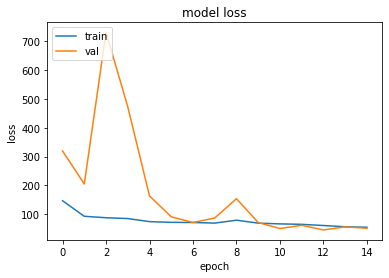

In [341]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Show the Lost After Training

In [342]:
#Load the best model
model = load_model('model-013-61.402420-46.173611.h5')
show_test_error(xTest,yTest,model)

938/938 [==============================] - 8s 9ms/step - loss: 45.3795
Test error:  45.37948989868164


# Test using real data from web

In [343]:
def test_thewebdata(imagepath,model):
    image=cv2.imread(imagepath)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    plt_imshow("Grayscale",image)
    image=image[25:325,50:350]
    plt_imshow("Image_Cropped",image)
    image=cv2.resize(image,(64,64),cv2.INTER_AREA)
    thresh,image=cv2.threshold(image,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    plt_imshow("Thresholded_resize",image)
    test_normalize=image/255
    test_normalize=test_normalize.reshape((1,64,64,1))
    result=model.predict(test_normalize)
    print("Result: ",result[0][0])
    return result

def test_onedata(imagepath,model):
    image=cv2.imread(imagepath)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    plt_imshow("Grayscale",image)
    image=image[0:125,20:145]
    plt_imshow("Image_Cropped",image)
    image=cv2.resize(image,(64,64),cv2.INTER_AREA)
    thresh,image=cv2.threshold(image,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    plt_imshow("Thresholded_resize",image)
    test_normalize=image/255
    test_normalize=test_normalize.reshape((1,64,64,1))
    result=model.predict(test_normalize)
    print("Result: ",result[0][0])
    return result

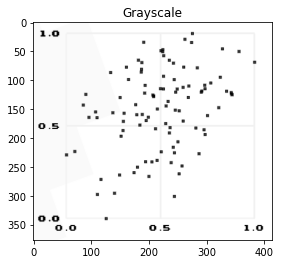

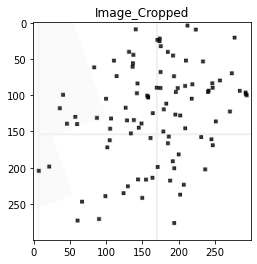

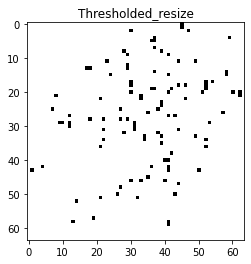

Result:  0.12583047


In [354]:
result=test_thewebdata("../Test_Website/20.PNG",model)

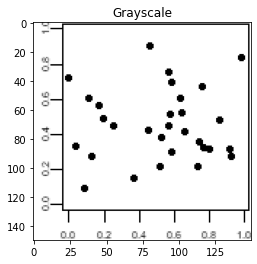

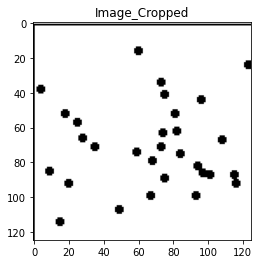

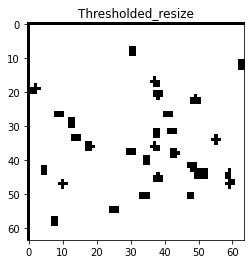

Result:  0.018847639


In [353]:
result=test_onedata("images/abydmeih.png",model)

# How to Improve

Use more advanced CNN Architecture,
Do a little more data analysis,
Do better image preprocessing,
If the dataset imbalance, we can do reweighting or resampling ,
Do dataset augmentation, for example rotate 180 degree